# Introduction to Machine Learning 2
Na-Rae Han, 10/19/2019

General machine learning work flow:
1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to the training data ("training")
4. Use the model to predict labels for new data
    - If labels are known (test data, aka 'gold' data), evaluate the performance. 

### Three types of ML:
https://jakevdp.github.io/PythonDataScienceHandbook/05.01-what-is-machine-learning.html

1. Regression: predicting continuous values
2. Classification: predicting discrete labels
3. **Clustering: inferring labels on unlabeled data**  <-- This one below

In [1]:
# Turns on/off pretty printing 
%pprint

# Every returned Out[] is displayed, not just the last one. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Pretty printing has been turned OFF


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn               # sklearn is the ML package we will use
import seaborn as sns        # seaborn graphical package

## Clustering: a type of unsupervised learning

- Using sklearn's pre-loaded data set "20 Newsgroups" 
- Code below is adapted from sklearn's official tutorial: 
  http://scikit-learn.org/stable/auto_examples/text/document_clustering.html 

Topic-based clustering is our goal:  
- Given a set of documents that are written on 4 topics, can they be grouped into 4 clusters? 

We will try **K-means clustering** method. 
- A good introduction article: https://www.datascience.com/blog/k-means-clustering
- sklearn's documentation: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html

In [3]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [4]:
# TfidfVectorizer is essentially CountVectorizer + TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
    # gets number count and then tfidf transformer in 1 step with TfidfVectorizer

### Data preparation step

In [5]:
from sklearn.datasets import fetch_20newsgroups

# We will use the same 4 categories
cats = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']

# Not using train-test split. Because this is un-supervised! 
dataset = fetch_20newsgroups(subset='all', categories=cats, shuffle=True, random_state=12)

In [6]:
type(dataset)

<class 'sklearn.datasets.base.Bunch'>

In [7]:
dir(dataset)

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']

In [8]:
dataset.data[5]

'From: vis@world.std.com (Tom R Courtney)\nSubject: Re: Space Marketing would be wonderfull.\nOrganization: The World Public Access UNIX, Brookline, MA\nLines: 17\n\nIn some sense, I think that the folks who think the idea is wonderful, and the\nfolks who want to boycott anyone who has anything to do with this project are\nboth right.\n\nThat is, I think that space advertising is an interesting idea, and if someone\nwants to try it out, more power to them. However, a company may discover that\nthe cost of launch is not the only cost of advertising, and a company who \ngauged that ill will would lose them more revenue than the advertising would\ngain might decide to bow out of the project.\n\nI got incensed when I read that Carl Sagan called this idea an "abomination." \nI don\'t think that word means what he thinks it does. Children starving in the\nrichest country in the world is an abomination; an ad agency is at worst just\nin poor taste.\n\nTom Courtney\n\n'

In [9]:
dataset.target
dataset.target[5]
dataset.target_names

array([2, 1, 2, ..., 3, 3, 2], dtype=int64)

1

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

In [10]:
len(dataset.data)

3585

In [11]:
# In our case, WE KNOW TRUE VALUE OF K: 4 topics. 
# But in many real-life use cases, true number of clusters will not be known,
#  and user must experiment with different K values. 

true_k = np.unique(dataset.target).shape[0]
print(true_k)

4


In [12]:
# Ignore words found in over 50% of documents, ignore words found in just 1 document. 
# 1000 most frequent words, remove stop words. 
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features=1000, stop_words='english')
X = vectorizer.fit_transform(dataset.data)
# uses sklearn's default tokenizer

# words that are too common aren't helpful in discerning topic, so throw away words in more than 1/2 of the docs
# only using the top 1000 words


# turned text into sparse vector notation

In [13]:
X[5]
print(X[5])
# 1x1000? "sparse matrix"? 

# looking at one doc, with 1000 features
# only contains 31 "yes in this document" features

# sparse matrix, because instead of showing all 1000 spaces, stores the values that are in the document in sparse matrix
# 31 calues that are part of top 1000 that aren't stop words

# shows location and tfidf value

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 31 stored elements in Compressed Sparse Row format>

  (0, 204)	0.0672523411448
  (0, 746)	0.105033387862
  (0, 180)	0.137895061559
  (0, 899)	0.318946488968
  (0, 826)	0.194510523256
  (0, 289)	0.0790109160299
  (0, 292)	0.0753453600121
  (0, 474)	0.0720597593222
  (0, 382)	0.117968021464
  (0, 711)	0.103870512588
  (0, 957)	0.0980917306138
  (0, 982)	0.271846319562
  (0, 697)	0.124447255719
  (0, 53)	0.118728321999
  (0, 923)	0.138473219002
  (0, 16)	0.124447255719
  (0, 787)	0.131302647881
  (0, 887)	0.313694855686
  (0, 429)	0.351672218256
  (0, 689)	0.265838807771
  (0, 449)	0.130831997331
  (0, 959)	0.153887024417
  (0, 909)	0.119059351145
  (0, 671)	0.12915907751
  (0, 216)	0.297109201319
  (0, 235)	0.280127897997
  (0, 495)	0.14325935292
  (0, 160)	0.116086406394
  (0, 977)	0.120763749157
  (0, 553)	0.122679382187
  (0, 60)	0.155757332972


In [14]:
vectorizer.vocabulary_.get('space')
vectorizer.get_feature_names()[204]
vectorizer.get_feature_names()[180]

826

'com'

'children'

### Data preparation complete. Time to apply K-means

In [15]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, verbose=True)
km.fit(X)

# true_k is 4 clusters
# don't want to iterate a lot, so won't go past 100
# verbose prints out log messages to tell you what to algorthim is doing


# between each iteration, tells you how good it is
# if it sees it won't get much better it will stop there
    # everyone willl have different number of iterations becausee the centroids start at random places

Initialization complete
Iteration  0, inertia 6531.503
Iteration  1, inertia 3381.913
Iteration  2, inertia 3347.023
Iteration  3, inertia 3328.463
Iteration  4, inertia 3317.935
Iteration  5, inertia 3315.324
Iteration  6, inertia 3314.853
Iteration  7, inertia 3314.743
Iteration  8, inertia 3314.682
Iteration  9, inertia 3314.642
Iteration 10, inertia 3314.627
Iteration 11, inertia 3314.622
Iteration 12, inertia 3314.619
Converged at iteration 12: center shift 0.000000e+00 within tolerance 9.553371e-08


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [16]:
# A bunch of metrics that compare target labels and labels as assigned by KM. 
print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset.target, km.labels_)) # labels as predicted by cluserting algorithm
print("Completeness: %0.3f" % metrics.completeness_score(dataset.target, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(dataset.target, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(dataset.target, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

# clustering gives labels (0,1,2,3)

# these numbers mean something, but....
    # need to know how to what the method is good for, what parameters it needs
    # need to use method in the right way
    
        # then you can claim you know how to use K-means-clustering

Homogeneity: 0.453
Completeness: 0.465
V-measure: 0.459
Adjusted Rand-Index: 0.456
Silhouette Coefficient: 0.016


In [17]:
# Top terms ("features") as ranked by centroids
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()
    
# found space, computer graphics, and a religion one, and on that seems prety random
# clustering algorythm doesn't know what it's clustering about

# (cluster number doesn't correspond to target labels)

Top terms per cluster:
Cluster 0: graphics university posting host nntp thanks image ac uk computer
Cluster 1: god jesus people christian church bible christ christians believe sin
Cluster 2: space nasa henry access digex gov toronto pat alaska shuttle
Cluster 3: com sandvik article kent apple netcom ibm don koresh newton


In [18]:
km.labels_[:20]        # Cluster labels as assigned by KMeans
dataset.target[:20]    # These are the real target labels
dataset.target_names

# Cluster 0 is graphics, target label 0
# Cluster 1 is relig Chris, target label 2
# cluster 2 is space, target label 1

array([1, 3, 0, 2, 1, 2, 1, 0, 0, 0, 1, 2, 3, 3, 3, 0, 1, 0, 3, 0])

array([2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 3, 2, 0, 3, 2, 3, 0], dtype=int64)

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

### Round 2. Let's try 3 clusters this time. 

- could be better to have 1 religion cluster even though origianlly given 4, beacuse the 2 religion ones are similar

In [23]:
km2 = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1, verbose=True)
km2.fit(X)

Initialization complete
Iteration  0, inertia 6556.930
Iteration  1, inertia 3361.587
Iteration  2, inertia 3338.413
Iteration  3, inertia 3336.083
Iteration  4, inertia 3335.352
Iteration  5, inertia 3335.115
Iteration  6, inertia 3334.988
Iteration  7, inertia 3334.898
Iteration  8, inertia 3334.861
Iteration  9, inertia 3334.832
Iteration 10, inertia 3334.821
Iteration 11, inertia 3334.812
Iteration 12, inertia 3334.804
Iteration 13, inertia 3334.798
Converged at iteration 13: center shift 0.000000e+00 within tolerance 9.553371e-08


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [24]:
print("Top terms per cluster:")
order_centroids = km2.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(3):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()
# Are the clusters looking better? 
# CAVEAT: could be local optimum, re-run to change

# i re-ran it a second time because church and christian were in the graphics one...

Top terms per cluster:
Cluster 0: com graphics university posting host nntp thanks image computer ac
Cluster 1: space nasa access henry digex gov pat toronto com alaska
Cluster 2: god jesus com people christian church christians bible christ don


In [21]:
km2.labels_[:20]        # Cluster labels as assigned by KMeans
dataset.target[:20]     # These are the real target labels
dataset.target_names

array([1, 2, 0, 2, 1, 2, 1, 0, 2, 2, 1, 2, 0, 1, 0, 2, 1, 0, 0, 2])

array([2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 3, 2, 0, 3, 2, 3, 0], dtype=int64)

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

In [25]:
# Newsgroup label -> KM label. Will need to adjust. 
labelmap = {0:0, 1:1, 2:2, 3:2}

target_conv = [labelmap[x] for x in dataset.target]
target_conv[:20]

[2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0]

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target_conv, km2.labels_)
cm

array([[ 961,    9,    3],
       [ 232,  747,    8],
       [ 272,    7, 1346]])

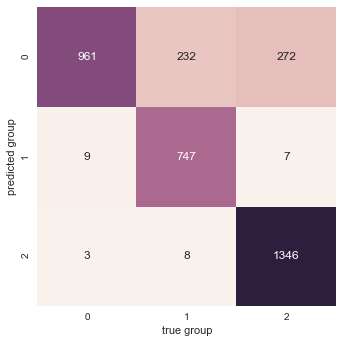

In [27]:
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true group')
plt.ylabel('predicted group')
plt.show()

# tended to get predicted as computer graphics
# clustering overpredicted to be part of computer category

# good for unsupervised learning because didn't have access to true labels

### Question: Can we produce nifty clustering visuals
such as the ones in tutorial/documentation: 
- https://www.datascience.com/blog/k-means-clustering
- http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_iris_004.png

??

Answer: NO - because we have 1000 features instead of 2-4


Linguistic data has so many features; text based ML is very different from other types

### Too Many Dimensions
This is where PCA (Principal Component Analysis) comes in. 
- Textbook chapter: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

skim through this chapter ^^     PCA helps with removing irrelevant features

More notes from Lecture: 

some dimensions are very low in predictive power

- we had 1000 features: can we go through and get rid of not-very-meaningful words?

### Testing on new, made up examples

In [28]:
# this worked in machine learning 1 but NOT here
    # because the model was built as a pipeline 
        # model=make_pipeline(TfidfVectorizer(), MultinomialNB())

tests = ['sending a payload to the ISS', 'I met Santa Claus once']
preds = km2.predict(tests)
print(preds)
#???

# km2 doesn't take direct texts: we trained it on the sparse matrix

ValueError: could not convert string to float: 'sending a payload to the ISS'

In [30]:
tests = ['sending a payload to the ISS space austronaut earth orbit', 'pray jesus I met Santa Claus once']
tests_tfidf = vectorizer.transform(tests)    # Yep, need this
preds = km2.predict(tests_tfidf)
print(preds)

[1 2]
